# Final Project

## Feature Prototype

### Project Idea 1: Deep Learning on a public dataset



In [1]:
# Importing Tensor flow and checking that the GPU is Recognized

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Load Data

In [2]:
# Importing Library to load the Dataset
from scipy.io import loadmat

# Change this names !!

train_raw = loadmat('../data/mat/train_32x32.mat')  # Train Set
test_raw = loadmat('../data/mat/test_32x32.mat')    # Test Set
extra_raw = loadmat('../data/mat/extra_32x32.mat')  # Extra Set

Below, I am splitting up the dataset into training data and training labels

In [4]:
import numpy as np

# Training Set & Labels
train_data = train_raw['X']
train_labels = train_raw['y']

# Extra Dataset & Labels
extra_data = extra_raw['X']
extra_labels = extra_raw['y']

# Test Data & Labels
test_data = test_raw['X']
test_labels = test_raw['y']

Below, I am checking the shape of each of the data and labels sets.

In [5]:
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('Test Data:', test_data.shape, 'Test Lables:', test_labels.shape)


Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
Test Data: (32, 32, 3, 26032) Test Lables: (26032, 1)


# Exploratory Analysis

Below, A function to plot the training image samples.

In [6]:
# Adapted From https://www.tensorflow.org/tutorials/load_data/images

# Import the matplotlib library for visualization
import matplotlib.pyplot as plt

def plot_sample_images(data, labels):

    # Create a new figure with a specific size of 10x10
    plt.figure(figsize=(10, 10))

    # Loop over the first 9 images in the dataset
    for i in range(9):
        
        # Create a subplot in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the i-th image from the 'train_data'    
        plt.imshow(data[:, :, :, i])
        
        # Set the title of the subplot to the corresponding label in 'train_labels'
        plt.title(labels[i])
        
        # Turn off the axis to remove ticks and labels for a cleaner display
        plt.axis("off")


Here are the first nine images from the training dataset.

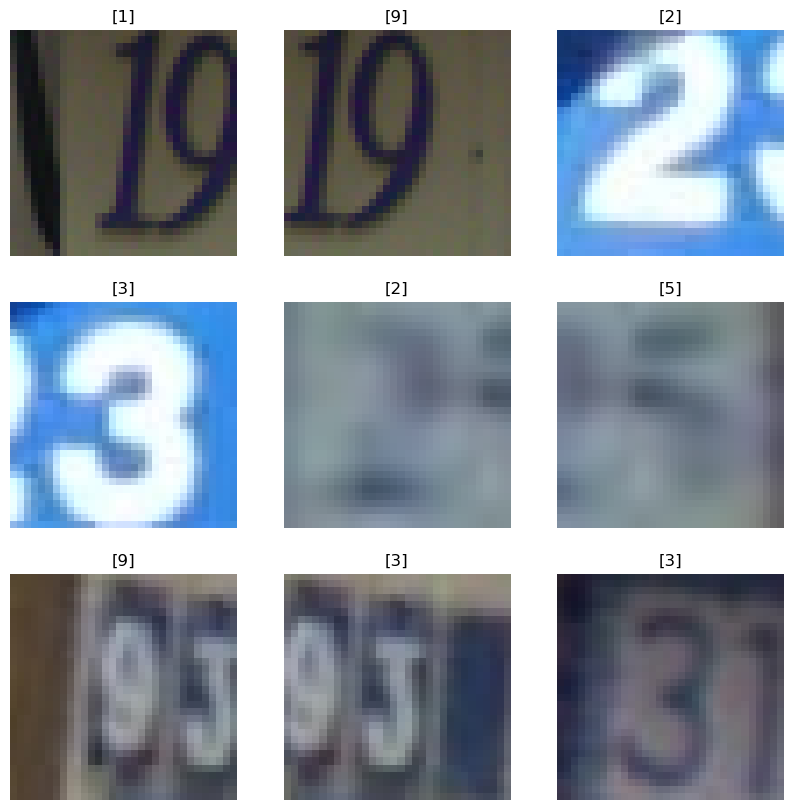

In [7]:
plot_sample_images(train_data, train_labels)

You can see that the 32 x 32 images contain distracting numbers to the side making it a real-world issue to solve.

Below, I am creating a function to display the distribution of the labels in the datasets.

In [8]:
import numpy as np
import seaborn as sns

def label_count_plot(labels, x_axis, y_axis, title, axis=None):
    """
    Creates a bar plot to visualize the count of unique labels in a dataset.

    Parameters:
    -----------
    labels : array-like
        A list, array, or similar structure containing categorical data.
    x_axis : str
        The label for the x-axis of the plot.
    y_axis : str
        The label for the y-axis of the plot.
    title : str
        The title of the bar plot.

    Returns: None
    --------
    """

    # Get unique labels and their counts from the input data
    unqique, counts = np.unique(labels, return_counts=True)

    # Combine the unique labels and their counts into a dictionary
    dict_counts =  dict(zip(unqique, counts))

    # Create a bar plot using Seaborn
    # x-axis: unique labels
    # y-axis: counts of each label
    # Set the axis labels and title of the plot
    sns.barplot(dict_counts, x=dict_counts.keys(), y= dict_counts.values(),
                 ax=axis).set(xlabel=x_axis, ylabel=y_axis, title=title) 


Plotting the datasets Label distributions.

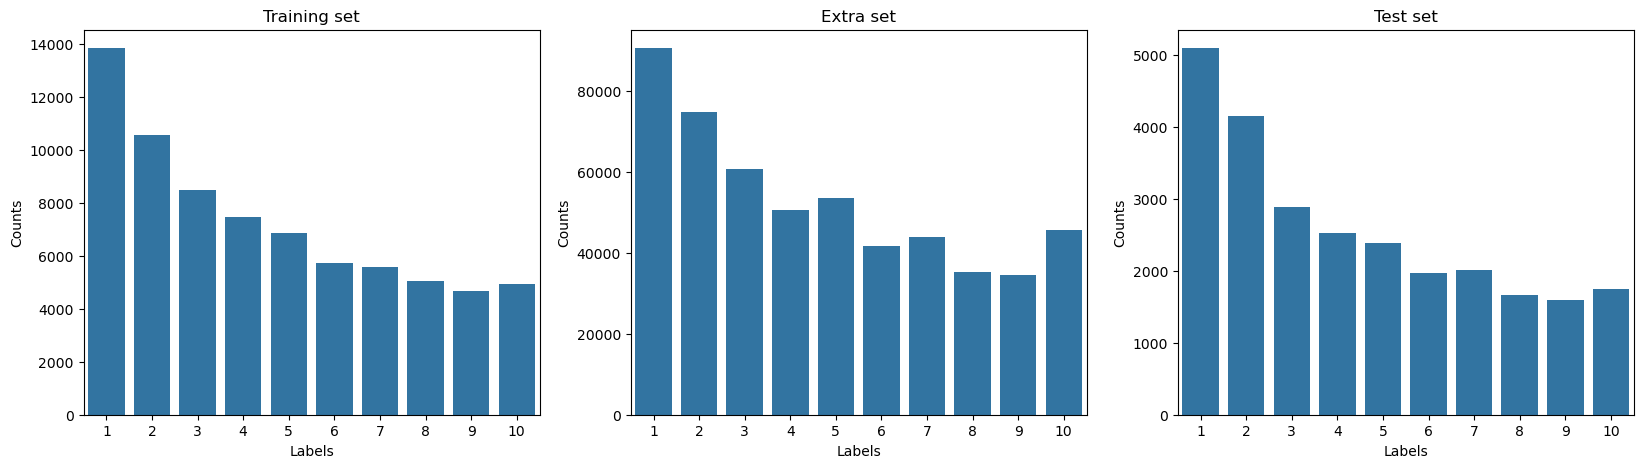

In [9]:
# Create a subplot in a 3x3 grid
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
label_count_plot(train_labels, "Labels", "Counts", "Training set", axis=ax[0])
label_count_plot(extra_labels, "Labels", "Counts", "Extra set", axis=ax[1])
label_count_plot(test_labels, "Labels", "Counts", "Test set", axis=ax[2])

You can see from the plots above that the data is imbalanced. I will have to address this imbalance in order to create an accurate model. All the dataset have more or less the same distribution imbalances.

# Pre-Processing

Here I will pre-process the dataset for training. I will be using the same method as ( Sermanet, Pierre, Chintala, Soumith, and LeCun, Yann ) in their paper 'Convolutional neural networks applied to house numbers digit classification'. 

In [10]:
# Function to create a validation set

def create_validation_set(X, y, num_samples_per_class):

    # Array: Stores the unique classes of label set
    unique_classes = np.unique(y)

    # List: To store chosen indexes                   
    chosen_indexes = []                             
    
    # Loop: iterate through each class
    for cls in unique_classes:                      

        # Array: Store all indexes from a class
        class_indexes = np.where(y == cls)[0]       

        # Array: Randomly select n indices from 'class_indexes'
        chosen_class_indexes = np.random.choice(class_indexes, num_samples_per_class, replace=False)
        # List:  Add each class indices to a list
        chosen_indexes.extend(chosen_class_indexes)

    # Array: Convert list to Numpy Array
    chosen_indexes = np.array(chosen_indexes)

    # Array:  Return the selected samples, label and indexes
    return X[:, :, :, chosen_indexes], y[chosen_indexes], chosen_indexes


## Validation Set
To build a validation set, we select 400 samples per class from the training set and 200 samples per class from the extra set. The remaining digits of the train and extra sets are used for training.

In [11]:
# Creating Validation Function

# Choose 400 samples from the training set for each class.
X_val_train, y_val_train, val_train_indexes = create_validation_set(train_data, train_labels, 400)

# Choose 200 samples from the extra set for each class.
X_val_extra, y_val_extra, val_extra_indexes = create_validation_set(extra_data, extra_labels, 200)

# Merge the two sets' validation samples.
X_val = np.concatenate((X_val_train, X_val_extra), axis=3)  # Combine along the 4th dimension
y_val = np.concatenate((y_val_train, y_val_extra), axis=0)

print('Validation data:', X_val.shape ,'Validation Labels:', y_val.shape)



Validation data: (32, 32, 3, 6000) Validation Labels: (6000, 1)


There are 6000 samples in the dataset.

Below, I am plotting the distribution of the validation set.

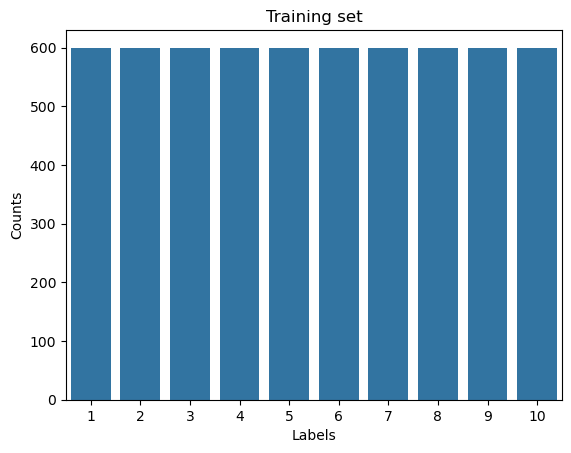

In [12]:
label_count_plot(y_val, "Labels", "Counts", "Training set")

The validation set has an equal distribution.

A function to Shuffle the datasets

In [13]:
def shuffle_dataset(data, labels):

    # Create a random number generator with a fixed seed
    seed = 42
    rng = np.random.default_rng(seed)

    # Generate indexes for the validation set
    shuffle_indexes = np.arange(labels.shape[0])  # Create an array of indexes
    rng.shuffle(shuffle_indexes)  # Shuffle the indexes in-place

    # Reorder X_val and y_val using the shuffled indexes
    shuffled_data = data[:, :, :, shuffle_indexes]
    shuffled_labels = labels[shuffle_indexes]

    return shuffled_data, shuffled_labels

Shuffling the Validation set

In [14]:
X_val, y_val = shuffle_dataset(X_val, y_val)

Plotting 9 sample from the validation set.

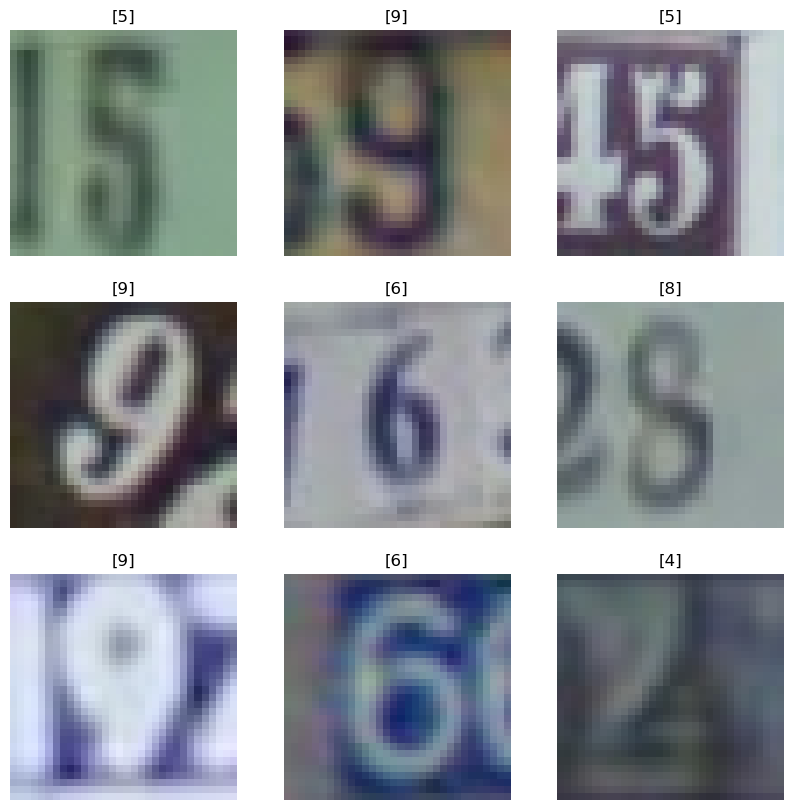

In [15]:
plot_sample_images(X_val, y_val)

## Training Set

Below, I will now remove the validation samples from the training and datasets.

In [16]:
# Remove validation samples from the original training set
X_train_new = np.delete(train_data, val_train_indexes, axis=3)
y_train_new = np.delete(train_labels, val_train_indexes, axis=0)

X_extra_new = np.delete(extra_data, val_extra_indexes, axis=3)
y_extra_new = np.delete(extra_labels, val_extra_indexes, axis=0)




print('===================================================================')
print('Original Shape')
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('===================================================================')
print('New Shape')
print('Training Data:', X_train_new.shape, 'Training Labels:', y_train_new.shape)
print('Extra Data:', X_extra_new.shape, 'Extra Lables:', y_extra_new.shape)

Original Shape
Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
New Shape
Training Data: (32, 32, 3, 69257) Training Labels: (69257, 1)
Extra Data: (32, 32, 3, 529131) Extra Lables: (529131, 1)


Above, You can see the new datasets size after removing the validation samples

Below, I will now merge the training set and extra set together to create 1 training set.

In [17]:
# Merge the two sets' training data samples.
X_train_merge = np.concatenate((X_train_new, X_extra_new), axis=3)  # Combine along the 4th dimension
y_train_merge = np.concatenate((y_train_new, y_extra_new), axis=0)

print('New training set Data:', X_train_merge.shape, 'New Training set Labels:', y_train_merge.shape)

New training set Data: (32, 32, 3, 598388) New Training set Labels: (598388, 1)


Above, You can see there are now just under 600,00 samples

Shuffling the Merged data set

In [18]:
X_train_merge, y_train_merge = shuffle_dataset(X_train_merge, y_train_merge)

Plotting the new merged dataset samples.

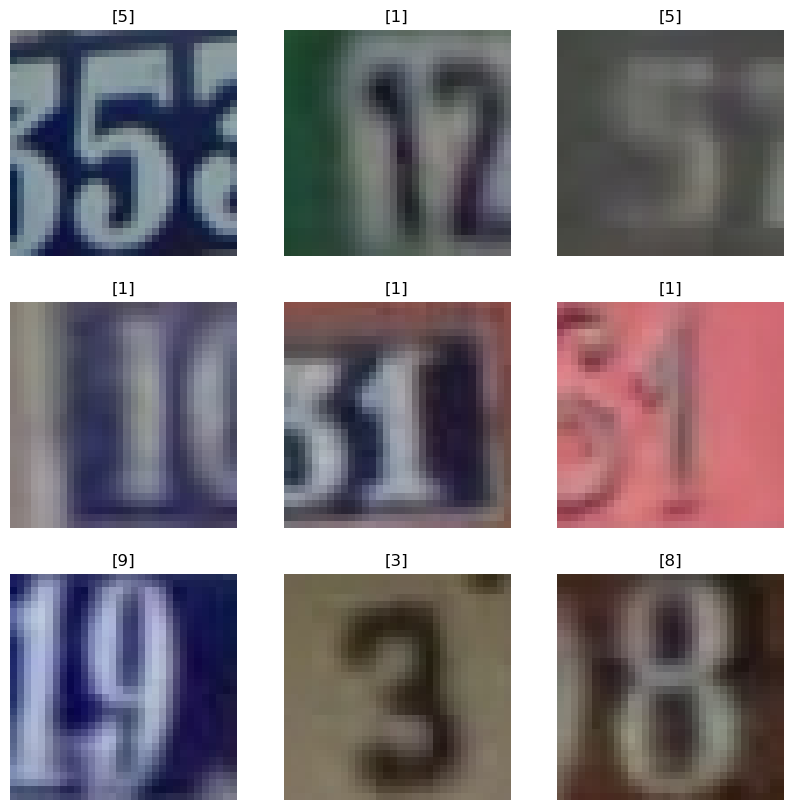

In [19]:
plot_sample_images(X_train_merge, y_train_merge)

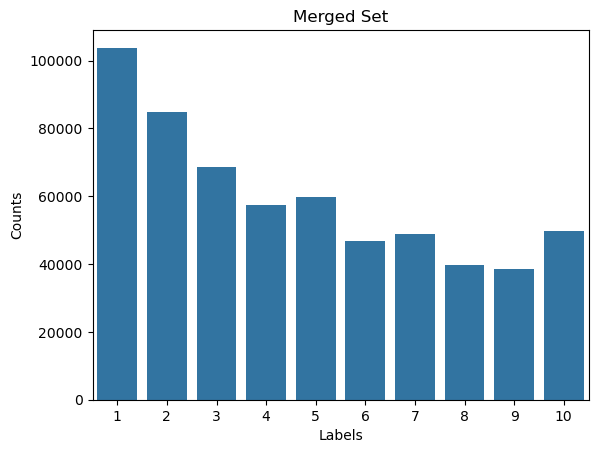

In [20]:
label_count_plot(y_train_merge, "Labels", "Counts", "Merged Set")

## Converting data types and Reshaping

Below, I am converting the training set to float32 and the label set to int32 for better compatibility with the Keras model.

In [21]:
# Convert sets to float32
X_train_float = X_train_merge.astype('float32')     # Training Set Data
X_val_float = X_val.astype('float32')               # Validation Set Data
test_data_float  = test_data.astype('float32')      # Test set Data

y_train_merge = y_train_merge.astype('int32')       # Train set Labels
y_val = y_val.astype('int32')                       # Validation set labels


Below, I am reshaping the data to better match the Tensorflow/Keras standard of (batch_size, height, width, depth)

In [22]:
#Reshape

X_train_reshaped = np.transpose(X_train_float, (3, 0, 1, 2))        # Shape: (32, 32, 3, 598388)
X_val_reshaped = np.transpose(X_val_float, (3, 0, 1, 2))            # Shape: (32, 32, 3, 6000)
test_data_reshaped = np.transpose(test_data_float, (3, 0, 1, 2))    # Shape: (32, 32, 3, 26032)


print("Training data", X_train_reshaped.shape, "Training Labels", y_train_merge.shape )
print("Validation data", X_val_reshaped.shape, "598388, 32, 32, Validation Labels", y_val.shape )
print("Test data", test_data_reshaped.shape, "Test Labels", test_labels.shape)

Training data (598388, 32, 32, 3) Training Labels (598388, 1)
Validation data (6000, 32, 32, 3) 598388, 32, 32, Validation Labels (6000, 1)
Test data (26032, 32, 32, 3) Test Labels (26032, 1)


In [23]:
len(X_train_reshaped)

598388

## Normalization

Normalize the data to a common scale for more efficient training.

In [24]:
# Create the Normalization object
norm_layer = tf.keras.layers.Normalization(axis=-1)

# Fit the training data to calculate the mean and Variance
norm_layer.adapt(X_train_reshaped)

In [25]:
print("Mean:", norm_layer.mean.numpy())  # Should output the computed mean
print("Variance:", norm_layer.variance.numpy())  # Should output the computed variance

Mean: [[[[109.867325 109.68633  113.773926]]]]
Variance: [[[[2511.743  2557.4934 2586.3638]]]]


Apply normalization to the training and validation sets.

In [26]:
# Normalize Data

with tf.device('/CPU:0'):
    X_train_normalized = norm_layer(X_train_reshaped)
    X_val_normalized = norm_layer(X_val_reshaped)

Checking the Images after normalization.

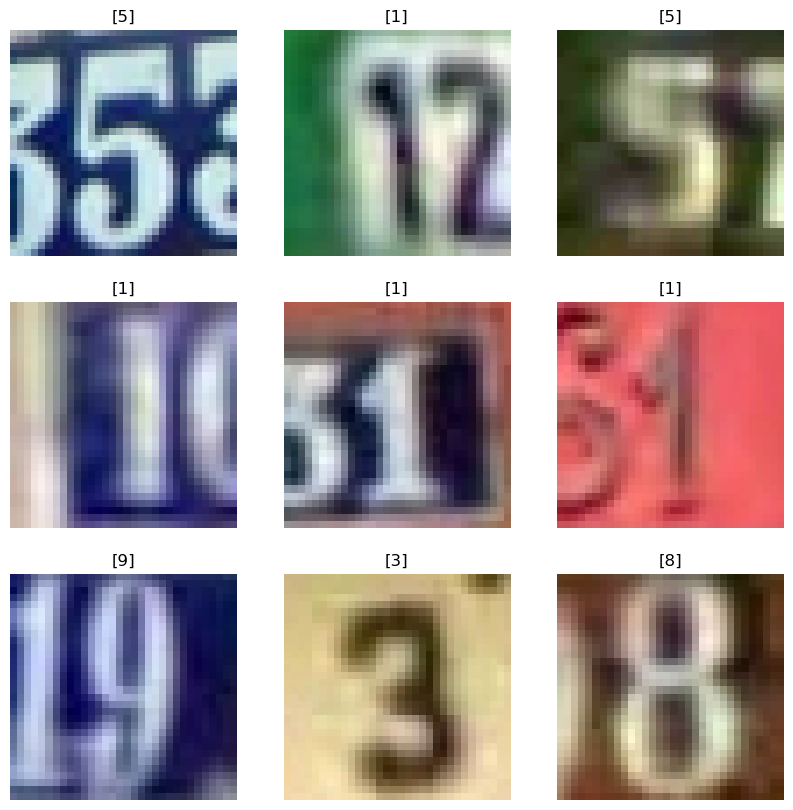

In [30]:

plt.figure(figsize=(10, 10))

# Loop over the first 9 images in the dataset
for i in range(9):
    
    # Create a subplot in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1)
    
    # https://stackoverflow.com/questions/1456000/rescaling-ranges
    rescaled_image = (X_train_normalized [i, :, :, :] - tf.reduce_min(
                          X_train_normalized [i, :, :, :])) / (tf.reduce_max(
                              X_train_normalized [i, :, :, :]) - tf.reduce_min(
                                  X_train_normalized [i, :, :, :]))

    # Display the i-th image from the 'train_data'    
    plt.imshow(rescaled_image)
    
    # Set the title of the subplot to the corresponding label in 'train_labels'
    plt.title(y_train_merge[i])
    
    # Turn off the axis to remove ticks and labels for a cleaner display
    plt.axis("off")


The images look brighter after normalization.

## Common Baseline Model

Since I know my data distribution is imbalanced I will calculate the sample weight for each class to get a accurate accuracy score for my baseline.

In [31]:
# Imbalanced Dataset Compute Class Weights
# https://www.geeksforgeeks.org/how-to-handle-class-imbalance-in-tensorflow/

from sklearn.utils import class_weight


# Reshape the labels for sample_weights
y_flat_cw = y_train_merge.flatten()

# calculate the sample weights
sp_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_flat_cw)

# Create a dictionary with the Sampple weights results
sample_weights = dict(enumerate(sp_weights))

Below, I need to convert the dictionary values to a numpy array so they can be processed by the dummy classier.

In [32]:
# class_weights_array = np.array(list(class_weights.values()))
# class_weights_array

# Convert the dictionary to a numpy array
sample_weights_array = np.array(list(sample_weights.values()))
sample_weights_array

array([1.00111758, 0.57636509, 1.00111758, ..., 1.28109786, 1.50337412,
       0.70627088])

Below, I need to flatten the training data so it can be used with the dummy classier.

In [33]:
# Reshaping for Dummy Classifier
# Let numpy figure out the shape automatically with -1

# Reshape the image data to (n_samples, n_features)
X_train_flattened = X_train_merge.reshape(X_train_merge.shape[3], -1)   # Shape: (598388, 32, 32, 3)
X_val_flattened = X_val.reshape(X_val.shape[3], -1)                     # Shape: (6000, 32, 32, 3)

print('Flattened Training data:', X_train_flattened.shape, 'Flattened Validation Data:', X_val_flattened.shape )

Flattened Training data: (598388, 3072) Flattened Validation Data: (6000, 3072)


Running the dummy classifier on the Training data and evaluating on the validation set. Calculating the accuracy

In [34]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Fit the dummy

# Initialize and fit DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

dummy_clf.fit(X_train_flattened, y_train_merge, sample_weight=sample_weights_array)


# Get predictions on the validation set
y_pred = dummy_clf.predict(X_val_flattened)

# Evaluate accuracy
baseline_accuracy = accuracy_score(y_val, y_pred)
print(f"Baseline Accuracy (Stratified): {baseline_accuracy * 100:.2f}%")

Baseline Accuracy (Stratified): 10.07%


The accuracy is currently around 10%, which is expected for a random guess in a balanced dataset with 10 classes (digits 0–9). I applied a sample weight dictionary to the model to assign higher weights to the underrepresented labels, ensuring that the model pays more attention to them during training. To demonstrate that the machine learning model is learning patterns in the data and achieving statistical accuracy, I would expect it to perform significantly better than 10% accuracy

## Converting Labels to a One hot encoded array

I am using the 'categorical_crossentropy' loss function which expects one hot encoded values. First I will change the way the digit 0 is labelled. At the moment digit 0 is labelled as 10. I will re-label it a 0

In [35]:
# Convert 10 to 0 for all label sets

import numpy as np

# Replace label 10 with 0
y_train_relabelled = np.where(y_train_merge == 10, 0, y_train_merge)
y_val_relabelled = np.where(y_val == 10, 0, y_val)
y_test_relabelled = np.where(test_labels == 10, 0, test_labels)

# Validate the labels
print("Unique values in adjusted y_train_merge:", np.unique(y_train_relabelled ))
print("Unique values in adjusted y_val:", np.unique(y_val_relabelled ))
print("Unique values in adjusted test_labels:", np.unique(y_test_relabelled ))

Unique values in adjusted y_train_merge: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted y_val: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted test_labels: [0 1 2 3 4 5 6 7 8 9]


One hot encoded the labels below.

In [36]:
# Import module
from sklearn.preprocessing import OneHotEncoder

# Fit the OneHotEncoder ot the training labels
enc = OneHotEncoder().fit(y_train_relabelled)

# Transform the label values to a one-hot-encoding scheme
y_train_oh = enc.transform(y_train_relabelled).toarray()
y_val_oh = enc.transform(y_val_relabelled).toarray()

Below, I am computing the class weights of the training data. This will be used with the classification model to make sure when the accuracy is calculated the imbalance is taken into account.

In [37]:
# Reference: https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding
from sklearn.utils import class_weight


y_integers = np.argmax(y_train_oh, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)

d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.1992224137239968,
 1: 0.5763650899143719,
 2: 0.7062708763647093,
 3: 0.8714980629751536,
 4: 1.0408376963350785,
 5: 1.0011175801378571,
 6: 1.2810978612258879,
 7: 1.2213994121489222,
 8: 1.5033741175288295,
 9: 1.5536492275736726}

# Simple Classification Model

for the first evaluation I will compare 2 models with the same architecture but using differentr activation functions. I want to confirm if Maxout networks offer any benefits over the Relu function. Before I proceed in fine tuning and using more sophisticated techniques.

The first model I will use will be focussed around the model in Maxout Networks by (Ian J. Goodfellow, David Warde-Farley, Mehdi Mirza, Aaron Courville, Yoshua Bengio) 2013. I will use the same structure of the model used in the paper but with the Relu activation function. In the second Model I will use the Maxout Activation function. The structure of both the model will be as follow:

1. Three Convolutional Layers:

    - As stated before the activation function will either be Maxout or Relu depending on the Model.

1. One Fully Connected Layer with activation function:

    - After the convolutional layers, a dense (fully connected) with either Maxout or Relu will be used.

1. One Fully Connected Softmax Layer:

    - A standard softmax layer is used at the output for final digit classification.

1. Dropout Regularization:

    - Dropout will be applied to each layer onf the model. I will use a setting of 0.2 for the convolutional layers and 0.5 for the dense layers.



## Model 1: Relu

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import activations

# Build the model
model_Relu = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  


    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_Relu.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_Relu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                  

In [ ]:
history = model_Relu.fit(
    X_train_normalized, y_train_oh,                 # Training data and labels
    validation_data=(X_val_normalized, y_val_oh),   # Validation data and labels
    batch_size=128,                                 # Number of samples per batch
    epochs=100,                                      # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.3388 - accuracy: 0.9020 - val_loss: 0.2786 - val_accuracy: 0.9247
Epoch 2/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.1847 - accuracy: 0.9493 - val_loss: 0.2332 - val_accuracy: 0.9337
Epoch 3/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1628 - accuracy: 0.9563 - val_loss: 0.2242 - val_accuracy: 0.9393
Epoch 4/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1511 - accuracy: 0.9591 - val_loss: 0.2076 - val_accuracy: 0.9415
Epoch 5/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1429 - accuracy: 0.9613 - val_loss: 0.2120 - val_accuracy: 0.9412
Epoch 6/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1392 - accuracy: 0.9626 - val_loss: 0.2015 - val_accuracy: 0.9430
Epoch 7/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1351 - accuracy: 0.9639 - val_loss: 0.2052 -

In [100]:
np.save('Relu_history.npy',history.history)

In [220]:
model_Relu.save("Relu_model.keras")

## Model 2: Maxout

In [109]:
import tensorflow as tf
import tensorflow_addons as tfa

# Build the model
model_maxout_v1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                  # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),    
    tfa.layers.Maxout(num_units=2),    

    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_maxout_v1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_maxout_v1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 dropout_67 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 maxout_57 (Maxout)          (None, 30, 30, 2)         0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 15, 15, 2)        0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 13, 13, 64)        1216      
                                                                 
 dropout_68 (Dropout)        (None, 13, 13, 64)        0         
                                                     

In [110]:
history_maxout_v1 = model_maxout_v1.fit(
    X_train_normalized, y_train_oh,                 # Training data and labels
    validation_data=(X_val_normalized, y_val_oh),   # Validation data and labels
    batch_size=128,                                 # Number of samples per batch
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 22s 5ms/step - loss: 1.5435 - accuracy: 0.4181 - val_loss: 2.1190 - val_accuracy: 0.2093
Epoch 2/100
4675/4675 [==============================] - 20s 4ms/step - loss: 1.2351 - accuracy: 0.5599 - val_loss: 2.2753 - val_accuracy: 0.2230
Epoch 3/100
4675/4675 [==============================] - 20s 4ms/step - loss: 1.1632 - accuracy: 0.5947 - val_loss: 2.4183 - val_accuracy: 0.2123
Epoch 4/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.1341 - accuracy: 0.6099 - val_loss: 2.5293 - val_accuracy: 0.2088
Epoch 5/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.1157 - accuracy: 0.6178 - val_loss: 2.5731 - val_accuracy: 0.2017
Epoch 6/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.1010 - accuracy: 0.6256 - val_loss: 2.6881 - val_accuracy: 0.1860
Epoch 7/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.0860 - accuracy: 0.6345 - val_loss: 2.6855 -

In [111]:
np.save('maxout_history_v1.npy',history_maxout_v1.history)

In [221]:
model_maxout_v1.save("model_maxout_v1.keras")

## Model 3: Maxout Version 2

In [105]:
import tensorflow as tf
import tensorflow_addons as tfa

# Build the model
model_maxout_v2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=16),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=32),                  # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=64),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),    
    tfa.layers.Maxout(num_units=64),    

    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_maxout_v2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_maxout_v2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 dropout_63 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 maxout_53 (Maxout)          (None, 30, 30, 16)        0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 13, 13, 64)        9280      
                                                                 
 dropout_64 (Dropout)        (None, 13, 13, 64)        0         
                                                     

In [107]:
history_maxout_v2 = model_maxout_v2.fit(
    X_train_normalized, y_train_oh,                 # Training data and labels
    validation_data=(X_val_normalized, y_val_oh),   # Validation data and labels
    batch_size=128,                                 # Number of samples per batch
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 33s 7ms/step - loss: 0.1406 - accuracy: 0.9618 - val_loss: 0.2177 - val_accuracy: 0.9415
Epoch 2/100
4675/4675 [==============================] - 33s 7ms/step - loss: 0.1381 - accuracy: 0.9623 - val_loss: 0.2176 - val_accuracy: 0.9423
Epoch 3/100
4675/4675 [==============================] - 33s 7ms/step - loss: 0.1374 - accuracy: 0.9625 - val_loss: 0.2194 - val_accuracy: 0.9425
Epoch 4/100
4675/4675 [==============================] - 33s 7ms/step - loss: 0.1359 - accuracy: 0.9628 - val_loss: 0.2161 - val_accuracy: 0.9437
Epoch 5/100
4675/4675 [==============================] - 33s 7ms/step - loss: 0.1355 - accuracy: 0.9632 - val_loss: 0.2103 - val_accuracy: 0.9460
Epoch 6/100
4675/4675 [==============================] - 33s 7ms/step - loss: 0.1341 - accuracy: 0.9634 - val_loss: 0.2206 - val_accuracy: 0.9462
Epoch 7/100
4675/4675 [==============================] - 32s 7ms/step - loss: 0.1327 - accuracy: 0.9641 - val_loss: 0.2102 -

In [108]:
np.save('maxout_history_v2.npy',history_maxout_v2.history)

In [223]:
model_maxout_v2.save("model_maxout_v2.keras")

# Results

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df_Relu = pd.DataFrame(history.history) 
hist_df_maxout_v1 = pd.DataFrame(history_maxout_v1.history) 
hist_df_maxout_v2= pd.DataFrame(history_maxout_v2.history)

In [175]:
# Concatenate Datasets together and assign Dataset column with a label 

concat_history = pd.concat([hist_df_Relu.assign(dataset='relu'), hist_df_maxout_v1.assign(dataset='maxout_v1'), hist_df_maxout_v2.assign(dataset='maxout_v2')])

In [ ]:
# Function to the plot Training and Validation Scores

import matplotlib.pyplot as plt

def plot_accuracy_metric(dataframe, plotname):

    accuracy = dataframe["accuracy"]
    val_accuracy = dataframe["val_accuracy"]
    loss = dataframe["loss"]
    val_loss = dataframe["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))


    # Subplot 1: Training and Validation Accuracy
    axes[0].plot(epochs, accuracy, "bo", label="Training accuracy")
    axes[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
    axes[0].set_title("Training and validation accuracy " + plotname)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    # plt.figure()
    # Subplot 2: Training and Validation Loss
    axes[1].plot(epochs, loss, "bo", label="Training loss")
    axes[1].plot(epochs, val_loss, "b", label="Validation loss")
    axes[1].set_title("Training and validation loss " + plotname)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

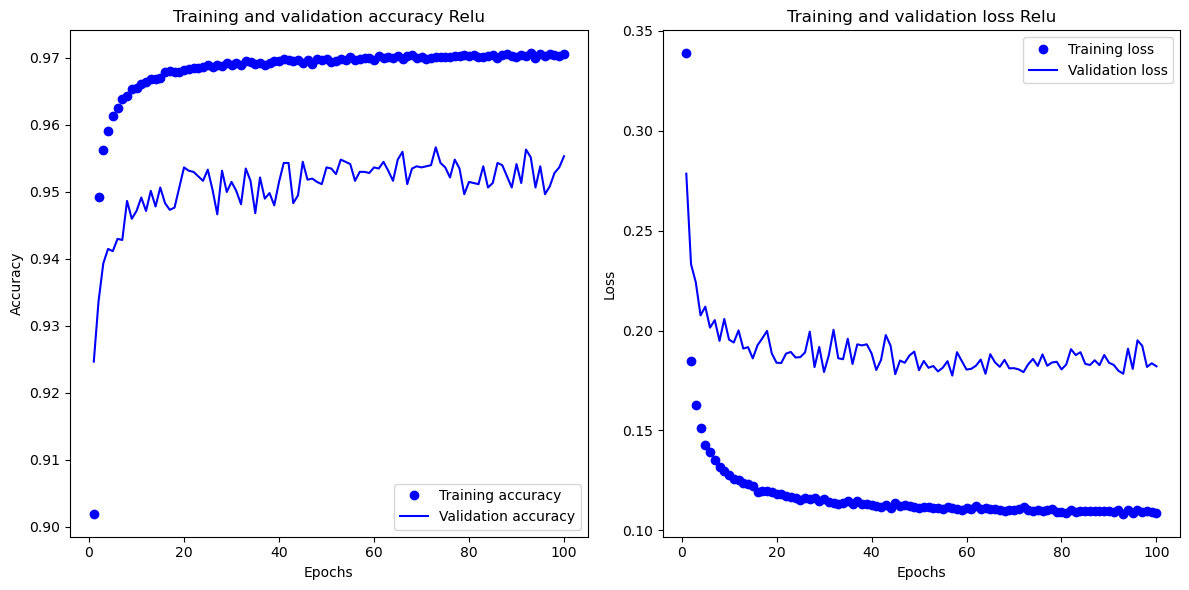

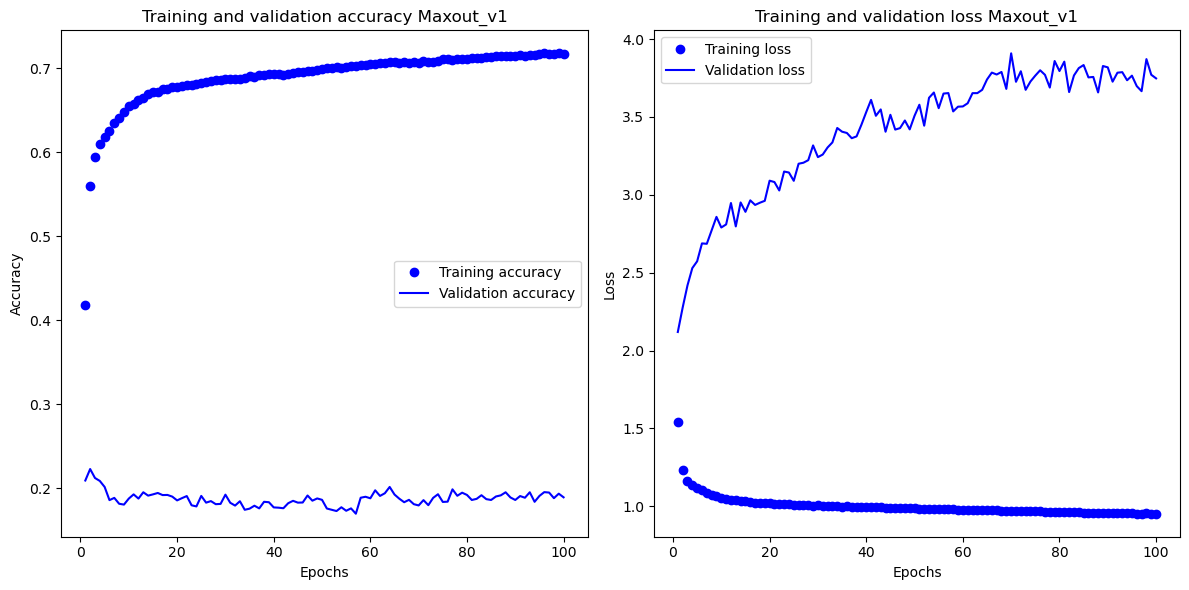

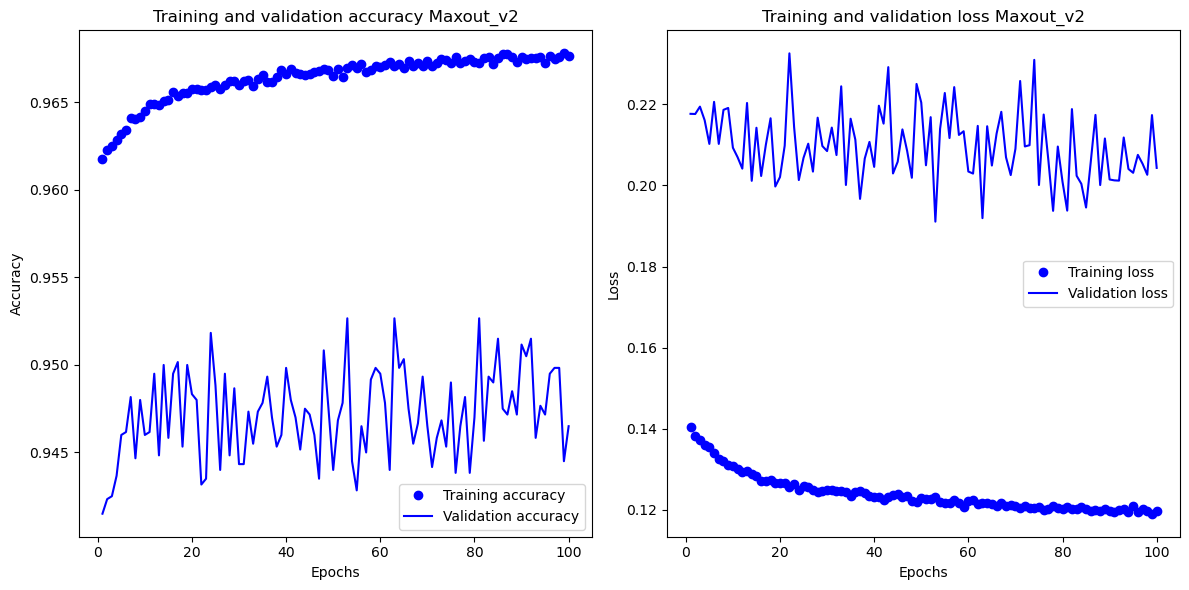

In [217]:
plot_accuracy_metric(hist_df_Relu, 'Relu')
plot_accuracy_metric(hist_df_maxout_v1, 'Maxout_v1')
plot_accuracy_metric(hist_df_maxout_v2, 'Maxout_v2')

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix

cm = confusion_matrix()

## Code Testing

In [38]:
from util_lcn import lcn



In [39]:
def global_contrast_normalization(X, s, lmda, epsilon):

    # replacement for the loop
    X_average = np.mean(X)
    # print('Mean: ', X_average)
    X = X - X_average

    # `su` is here the mean, instead of the sum
    contrast = np.sqrt(lmda + np.mean(X**2))

    X = s * X / max(contrast, epsilon)

    return X

In [40]:
def rescale_image(image):

    rescaled_image = (image - tf.reduce_min(
                            image )) / (tf.reduce_max(
                               image ) - tf.reduce_min(
                                    image ))
    
    return rescaled_image

In [41]:
def gaussian_kernel(kernal_size, sigma):

    kernel = np.fromfunction(lambda x, y: (1 / (2 * np.pi * sigma**2))
                             * np.exp(-((x - kernal_size//2)**2 +  (y - kernal_size//2)**2) / (2 * sigma**2)),
                             (kernal_size, kernal_size))
    normal = kernel / np.sum(kernel)
    return normal
kernel_size = 7
sigma = 1.0

gaussian_matrix = gaussian_kernel(kernel_size, sigma)

gaussian_matrix.astype('float32')

print(gaussian_matrix)

[[1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [1.76900911e-03 2.15509428e-02 9.65846250e-02 1.59241126e-01
  9.65846250e-02 2.15509428e-02 1.76900911e-03]
 [1.07295826e-03 1.30713076e-02 5.85815363e-02 9.65846250e-02
  5.85815363e-02 1.30713076e-02 1.07295826e-03]
 [2.39409349e-04 2.91660295e-03 1.30713076e-02 2.15509428e-02
  1.30713076e-02 2.91660295e-03 2.39409349e-04]
 [1.96519161e-05 2.39409349e-04 1.07295826e-03 1.76900911e-03
  1.07295826e-03 2.39409349e-04 1.96519161e-05]]


(32, 32, 3) uint8 <class 'numpy.ndarray'>


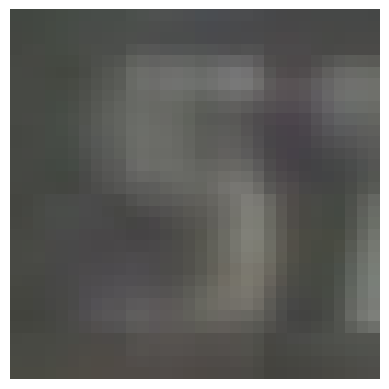

In [42]:
import tensorflow_io as tfio

image = X_train_reshaped[2, :, :, :]
# image = X_train_normalized[0, :, :, :]



# yuv = tfio.experimental.color.rgb_to_yuv(image)
image = image.astype('uint8')

print(image.shape, image.dtype, type(image))

plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [43]:
for i in range(0,10):

        image = X_train_reshaped[i, :, :, :]

In [130]:
import tensorflow_io as tfio
import importlib
import util_lcn
importlib.reload(util_lcn)
from util_lcn import lcn


def local_contrast(matrix_4d, matrix ):

    z = np.copy(matrix_4d)
    
    # for i in range(len(matrix_4d)):
    for i in range(len(z)):
        # print(i)

        image = z[i, :, :, :]

        # Rescale Image for the RGB_YUV function
        image = image / 255.

        yuv_image = tfio.experimental.color.rgb_to_yuv(image)

        # Convert to numpy for item assignment
        yuv_image =  yuv_image.numpy()

        # print(yuv_image.shape)

        # Apply Local contrast Normalisation on the Y channel
        lcn_image = lcn(yuv_image[:,:,0], matrix)

        # Assign Y_LCN back to Image YUV matrix
        # yuv_image[:,:,0] = lcn_image.astype('float32')
        yuv_image[:,:,0] = lcn_image
        # print(lcn_image.max(), lcn_image.min())

        for j in range(yuv_image.shape[2]):
            contrast = global_contrast_normalization(yuv_image[:,:,j],1, 1, 0.000000001 )
            yuv_image[:,:,j] = contrast
        # print(yuv_image[:,:,0].max(), yuv_image[:,:,0].min())
        yuv_image = tfio.experimental.color.yuv_to_rgb(yuv_image)

        z[i, :, :, :] = yuv_image

    return z
            



In [131]:
X_lcn_y = local_contrast(X_train_reshaped[0:10], gaussian_matrix )

In [86]:
val_lcn_y = local_contrast(X_val_reshaped, gaussian_matrix )

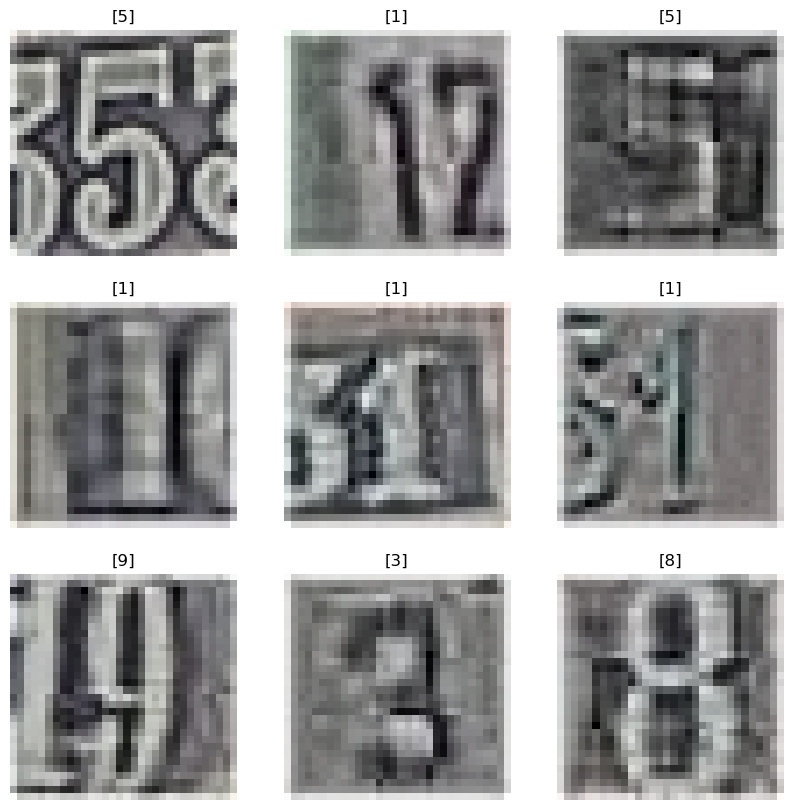

In [132]:
plt.figure(figsize=(10, 10))

# Loop over the first 9 images in the dataset
for i in range(9):
    
    # Create a subplot in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1)
    
    # https://stackoverflow.com/questions/1456000/rescaling-ranges
    rescaled_image = (X_lcn_y [i, :, :, :] - tf.reduce_min(
                          X_lcn_y [i, :, :, :])) / (tf.reduce_max(
                              X_lcn_y [i, :, :, :]) - tf.reduce_min(
                                  X_lcn_y [i, :, :, :]))

    # Display the i-th image from the 'train_data'    
    plt.imshow(rescaled_image)
    
    # Set the title of the subplot to the corresponding label in 'train_labels'
    plt.title(y_train_merge[i])
    
    # Turn off the axis to remove ticks and labels for a cleaner display
    plt.axis("off")

In [565]:
norm_layer_lcn = tf.keras.layers.Normalization(axis=-1)

with tf.device('/CPU:0'):
    norm_layer_lcn.adapt(X_lcn_y)

In [573]:
with tf.device('/CPU:0'):
    X_train_normalized_lcn = norm_layer_lcn(X_lcn_y)
    X_val_normalized_lcn = norm_layer_lcn(val_lcn_y)

In [88]:
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_lcn_y, y_train_oh))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_lcn_y, y_val_oh))


In [89]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [90]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import activations

# Build the model
model_Relu_lcn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  


    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_Relu_lcn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_Relu_lcn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 dropout_13 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                 

In [91]:
# This callback will stop the training when there is no improvement in
# the loss for 5 consecutive epochs.

from keras import callbacks

callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)


history_lcn_relu = model_Relu_lcn.fit(
    # X_train_normalized_lcn, y_train_oh,                 # Training data and labels
    train_dataset,                 # Training data and labels
    # validation_data=(X_val_normalized_lcn, y_val_oh),   # Validation data and labels
    validation_data=val_dataset,   # Validation data and labels
    # batch_size=128,                                 # Number of samples per batch
    epochs=100,                                      # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[callback],
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.3387 - accuracy: 0.8999 - val_loss: 0.3144 - val_accuracy: 0.9112
Epoch 2/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.2012 - accuracy: 0.9434 - val_loss: 0.2888 - val_accuracy: 0.9188
Epoch 3/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.1779 - accuracy: 0.9498 - val_loss: 0.2782 - val_accuracy: 0.9218
Epoch 4/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1655 - accuracy: 0.9540 - val_loss: 0.2566 - val_accuracy: 0.9270
Epoch 5/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.1576 - accuracy: 0.9560 - val_loss: 0.2519 - val_accuracy: 0.9288
Epoch 6/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.1527 - accuracy: 0.9571 - val_loss: 0.2439 - val_accuracy: 0.9323
Epoch 7/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.1477 - accuracy: 0.9586 - val_loss: 0.2461 -

In [75]:
import tensorflow as tf
import tensorflow_addons as tfa

# Build the model
model_maxout_v1_lcn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                  # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),    
    tfa.layers.Maxout(num_units=2),    

    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_maxout_v1_lcn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_maxout_v1_lcn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 maxout (Maxout)             (None, 30, 30, 2)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        1216      
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 64)        0         
                                                        

In [ ]:
# This callback will stop the training when there is no improvement in
# the loss for 5 consecutive epochs.

from keras import callbacks

callback = callbacks.EarlyStopping(monitor='val_loss', patience=3)


history_maxout_v1_lcn = model_maxout_v1_lcn.fit(
    # X_train_normalized_lcn, y_train_oh,                 # Training data and labels
    train_dataset,                 # Training data and labels
    # validation_data=(X_val_normalized_lcn, y_val_oh),   # Validation data and labels
    validation_data=(val_dataset),   # Validation data and labels
    # batch_size=128,                                 # Number of samples per batch
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[callback],
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.8260 - accuracy: 0.3091 - val_loss: 2.3915 - val_accuracy: 0.1635
Epoch 2/100
4675/4675 [==============================] - 20s 4ms/step - loss: 1.4498 - accuracy: 0.4391 - val_loss: 2.8180 - val_accuracy: 0.1737
Epoch 3/100
4675/4675 [==============================] - 20s 4ms/step - loss: 1.3285 - accuracy: 0.5109 - val_loss: 2.9294 - val_accuracy: 0.1777
Epoch 4/100
4675/4675 [==============================] - 20s 4ms/step - loss: 1.2724 - accuracy: 0.5492 - val_loss: 2.9834 - val_accuracy: 0.1730


In [78]:
import tensorflow as tf
import tensorflow_addons as tfa

# Build the model
model_maxout_v2_lcn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=16),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=32),                  # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=64),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),    
    tfa.layers.Maxout(num_units=64),    

    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_maxout_v2_lcn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_maxout_v2_lcn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 dropout_8 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 maxout_8 (Maxout)           (None, 30, 30, 16)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        9280      
                                                                 
 dropout_9 (Dropout)         (None, 13, 13, 64)        0         
                                                      

In [83]:
# This callback will stop the training when there is no improvement in
# the loss for 5 consecutive epochs.

from keras import callbacks

callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)


history_maxout_v2 = model_maxout_v2_lcn.fit(
    # X_train_normalized, y_train_oh,                 # Training data and labels
    train_dataset,                 # Training data and labels
    # validation_data=(X_val_normalized, y_val_oh),   # Validation data and labels
    validation_data=(val_dataset),   # Validation data and labels
    # batch_size=128,                                 # Number of samples per batch
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[callback],
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1440 - accuracy: 0.9594 - val_loss: 0.2298 - val_accuracy: 0.9333
Epoch 2/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1436 - accuracy: 0.9595 - val_loss: 0.2332 - val_accuracy: 0.9332
Epoch 3/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1421 - accuracy: 0.9596 - val_loss: 0.2409 - val_accuracy: 0.9282
Epoch 4/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1423 - accuracy: 0.9596 - val_loss: 0.2512 - val_accuracy: 0.9307
Epoch 5/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.1424 - accuracy: 0.9595 - val_loss: 0.2399 - val_accuracy: 0.9310
Epoch 6/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.1412 - accuracy: 0.9600 - val_loss: 0.2324 - val_accuracy: 0.9313
Epoch 7/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1417 - accuracy: 0.9600 - val_loss: 0.2282 -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6495283..1.5357628].


1 float32 float32 0.105882354 0.83137256
2 (32, 32, 3) <dtype: 'float32'> <class 'tensorflow.python.framework.ops.EagerTensor'> <dtype: 'float32'>
3 (32, 32, 3) float32 <class 'numpy.ndarray'>
4 (32, 32) float64 <class 'numpy.ndarray'>
5 (32, 32, 3) float32 <class 'numpy.ndarray'> float32


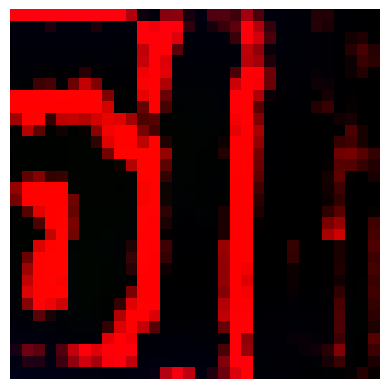

array([[ 1.19753916,  1.12919046,  1.18689856, ..., -0.02790669,
        -0.06233408, -0.22469819],
       [-0.18013983, -0.31513659, -0.19581278, ..., -0.02425758,
        -0.05086787, -0.23983442],
       [-1.00133129, -1.36042286, -1.20064339, ...,  0.07761393,
         0.12040263, -0.03836917],
       ...,
       [ 0.08760786,  0.43199455,  0.35749015, ..., -0.25653525,
        -0.3522088 ,  0.23856178],
       [-0.09475003,  0.13293981,  0.12521234, ..., -0.11577792,
        -0.13151097,  0.10358186],
       [-0.57450696, -0.69354563, -0.67378551, ...,  0.03046311,
         0.14415479,  0.0308121 ]])

In [372]:
# Converting to YUV Space and apply LCN to Y channel

import tensorflow_io as tfio

image = X_train_reshaped[2, :, :, :]
# image = X_train_normalized[2, :, :, :]


# Rescale Image for the RGB_YUV function
image = image / 255.

print('1', image.dtype, kernel.dtype,  image.min(), image.max())

# Convert to YUV Colour
yuv = tfio.experimental.color.rgb_to_yuv(image)



print('2',yuv.shape, yuv.dtype, type(yuv), yuv[:,:,0].dtype)

# Convert to numpy item assignment
yuv =  yuv.numpy()

print('3',yuv.shape, yuv.dtype, type(yuv))

# Apply Local contrast Normalisation on the Y channel
lcn_image = lcn(yuv[:,:,0], gaussian_matrix)

# Assign Y_LCN back to Image YUV matrix
yuv[:,:,0] = lcn_image.astype('float32')


print('4',lcn_image.shape, lcn_image.dtype, type(lcn_image))
print('5',yuv.shape, yuv.dtype, type(yuv), yuv[:,:,0].dtype)

plt.figure()
plt.imshow(yuv)
plt.axis('off')
plt.show()

lcn_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2606075..1.2553341].


3 (32, 32, 3) float32 <class 'numpy.ndarray'>
Mean:  -0.05354465
Mean:  -1.9087805e-05
Mean:  0.014567425


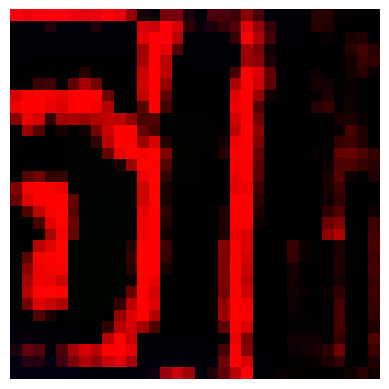

In [373]:
# Apply Global contrast Normalization to all channels

yuv_2 = yuv

print('3',yuv_2.shape, yuv_2.dtype, type(yuv_2))

y = global_contrast_normalization(yuv_2[:,:,0],1, 1, 0.000000001 )
# y = rescale_image(y)
u = global_contrast_normalization(yuv_2[:,:,1],1, 1, 0.000000001 )
# u = rescale_image(u)
v = global_contrast_normalization(yuv_2[:,:,2],0.1, 1, 0.000000001 )
# v = rescale_image(v)

yuv_2[:,:,0], yuv_2[:,:,1], yuv_2[:,:,2] = y, u , v

plt.figure()
plt.imshow(yuv_2)
plt.axis('off')
plt.show()



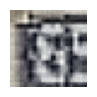

In [497]:
# Converting back to RGB to display

# rgb_2 = tfio.experimental.color.yuv_to_rgb(X_lcn_y[1,:,:,:])
# rgb_2 = tfio.experimental.color.yuv_to_rgb(X_train_reshaped[0,:,:,:])
rgb_2  =  rgb_2 .numpy()
r = rescale_image(rgb_2[:,:,0])
g = rescale_image(rgb_2[:,:,1])
b = rescale_image(rgb_2[:,:,2])

rgb_2[:,:,0], rgb_2[:,:,1], rgb_2[:,:,2] = r, g, b


plt.figure(figsize=(1, 1))
# plt.figure()
plt.imshow(X_lcn_y[1,:,:,:])
plt.axis('off')
plt.show()


In [47]:
X_train_merge[:,:,:,0].shape

(32, 32, 3)

tf.Tensor(0.105882354, shape=(), dtype=float32) tf.Tensor(0.83137256, shape=(), dtype=float32)
(32, 32, 3)
(32, 32, 3) <dtype: 'float32'>


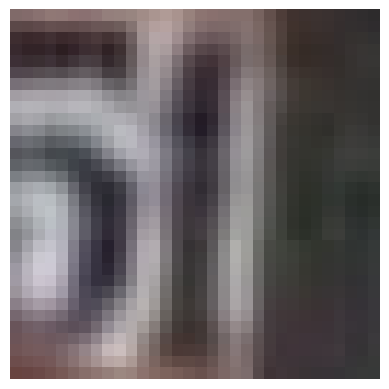

In [269]:
import tensorflow_io as tfio

image = tf.cast(X_train_merge[:,:,:,2], tf.float32) / 255.0
# image = X_train_normalized[0, :, :, :]



print(tf.reduce_min(image), tf.reduce_max(image))
print(image.shape)


yuv = tfio.experimental.color.rgb_to_yuv(image)

print(yuv.shape, yuv.dtype)


plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

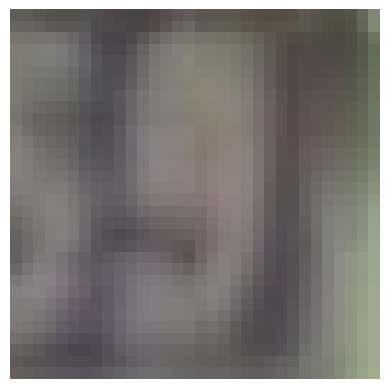

In [29]:


plt.figure()
plt.imshow(X_train_reshaped[0, :, :, :].astype('int32'))
plt.axis('off')
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create confusion matrix

cm

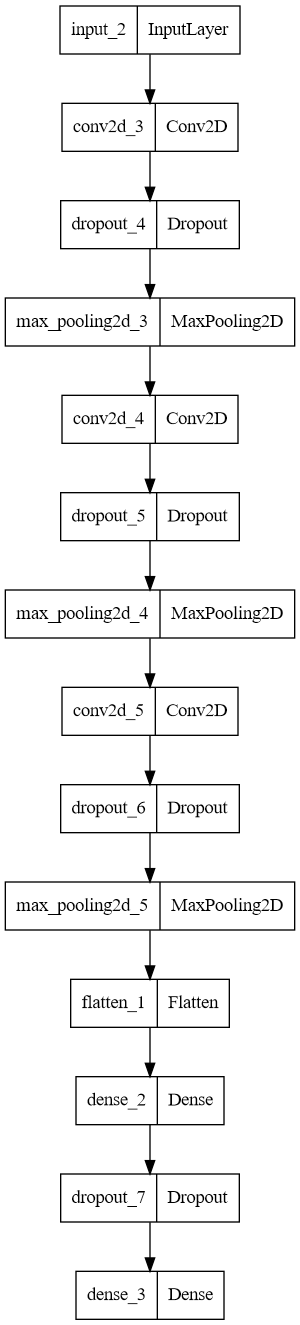

In [ ]:
from keras.utils import plot_model

plot_model(model_Relu, to_file='model_Relu.png')

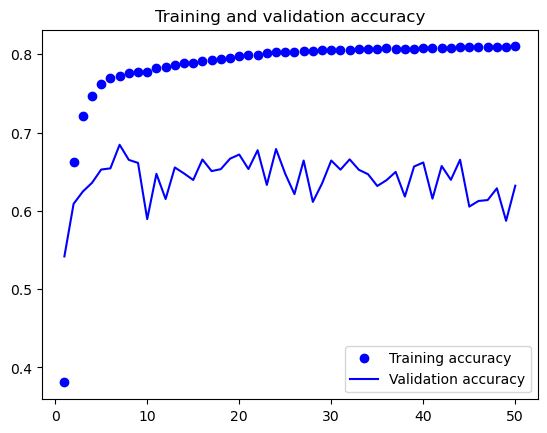

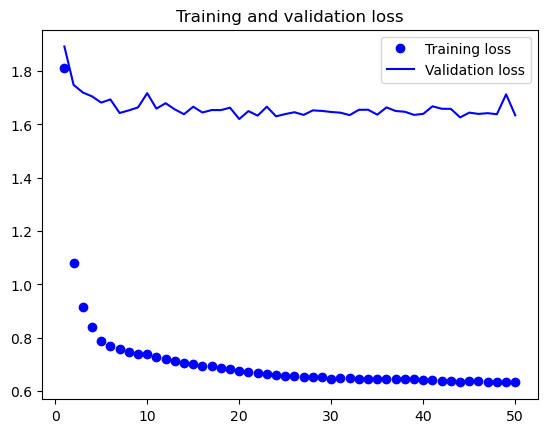

In [ ]:
# Code taken from Deep Learning with Python, Second Edition Chapter 8 Listing 8.12

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [66]:
import gc
import tensorflow as tf

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

In [61]:
# New parameters model
# model_07/12_12:00_epochs

import tensorflow as tf
import tensorflow_addons as tfa
from keras.constraints import max_norm
from keras.optimizers import Adam

# Build the model
model_4 = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    # tf.keras.layers.Dropout(.1),              

    # tf.keras.layers.Conv2D(32, (5, 5), strides=(1, 1), padding="same", kernel_constraint=max_norm(4)),                              
    tf.keras.layers.Conv2D(1024, (5, 5), strides=(1, 1), padding="same"), 
    tf.keras.layers.Dropout(.5),                             
    tfa.layers.Maxout(num_units=2),                   
                     
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    

    # tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)),              
    tf.keras.layers.Conv2D(2048, (5, 5), strides=(1, 1), padding="same"),  
    tf.keras.layers.Dropout(.5),             
    tfa.layers.Maxout(num_units=2),                   #
                      #
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    

    # tf.keras.layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)),              
    tf.keras.layers.Conv2D(4096, (5, 5), strides=(1, 1), padding="same"), 
    tf.keras.layers.Dropout(.5),             
    tfa.layers.Maxout(num_units=2),                   
                  
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    


    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(128,kernel_constraint=max_norm(4)),   
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Dropout(.5),   
    tfa.layers.Maxout(num_units=2),
 
    
    # tf.keras.layers.Dense(10, activation='softmax', kernel_constraint=max_norm(4))    # Output layer for 10 classes
    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
optimizer = Adam(beta_1=0.95)
model_4.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 32, 32, 1024)      77824     
                                                                 
 dropout_39 (Dropout)        (None, 32, 32, 1024)      0         
                                                                 
 maxout_45 (Maxout)          (None, 32, 32, 2)         0         
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 2)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 15, 15, 2048)      104448    
                                                                 
 dropout_40 (Dropout)        (None, 15, 15, 2048)      0         
                                                      

In [62]:
history = model_4.fit(
    X_train_normalized, y_train_oh,                # Training data and labels
    validation_data=(X_val_normalized, y_val_oh),  # Validation data and labels
    batch_size=128,                   # Number of samples per batch
    epochs=100,                       # Number of epochs
    class_weight=d_class_weights,
    verbose=1                        # Verbosity mode (1 for progress bar)
)

Epoch 1/100
 229/4675 [>.............................] - ETA: 8:58 - loss: 2.3055 - accuracy: 0.1340

KeyboardInterrupt: 

In [ ]:
# New Parameters Model

import tensorflow as tf
import tensorflow_addons as tfa
from keras.constraints import max_norm
from keras.optimizers import Adam

# Build the model
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    tf.keras.layers.Dropout(.1),              

    tf.keras.layers.Conv2D(96, (5, 5), strides=(1, 1), padding="same", kernel_constraint=max_norm(4)),  
    tfa.layers.Maxout(num_units=2),                         
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.25),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)), 
    tfa.layers.Maxout(num_units=2),                       #
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.25),

    tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)),
    tfa.layers.Maxout(num_units=2),                   
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.5),
  
    tf.keras.layers.Flatten(),
        
    tf.keras.layers.Dense(512,kernel_constraint=max_norm(4)),
    tfa.layers.Maxout(num_units=2),
    # tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.5),

    

    tf.keras.layers.Dense(10, activation='softmax', kernel_constraint=max_norm(4))    # Output layer for 10 classes
])

# Compile the model
optimizer = Adam(beta_1=0.95)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 96)        7296      
                                                                 
 maxout (Maxout)             (None, 32, 32, 2)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 2)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 2)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       6528      
                                                        

In [ ]:
history = model.fit(
    X_train_reshaped, y_train_flatten,                # Training data and labels
    validation_data=(X_val_reshaped, y_val_flatten),  # Validation data and labels
    batch_size=2048,                   # Number of samples per batch
    epochs=50,                       # Number of epochs
    class_weight=class_weights,
    verbose=1                        # Verbosity mode (1 for progress bar)
)

Epoch 1/50
293/293 [==============================] - 31s 103ms/step - loss: 2.4519 - accuracy: 0.1013 - val_loss: 2.3028 - val_accuracy: 0.1132
Epoch 2/50
293/293 [==============================] - 30s 101ms/step - loss: 2.2848 - accuracy: 0.1292 - val_loss: 2.2323 - val_accuracy: 0.1878
Epoch 3/50
293/293 [==============================] - 30s 101ms/step - loss: 2.2197 - accuracy: 0.1751 - val_loss: 2.1126 - val_accuracy: 0.2703
Epoch 4/50
293/293 [==============================] - 30s 101ms/step - loss: 2.1603 - accuracy: 0.1762 - val_loss: 2.0461 - val_accuracy: 0.2732
Epoch 5/50
293/293 [==============================] - 30s 101ms/step - loss: 2.0963 - accuracy: 0.1854 - val_loss: 1.9493 - val_accuracy: 0.2880
Epoch 6/50
293/293 [==============================] - 30s 102ms/step - loss: 2.0540 - accuracy: 0.1934 - val_loss: 2.0450 - val_accuracy: 0.2702
Epoch 7/50
293/293 [==============================] - 30s 102ms/step - loss: 2.0329 - accuracy: 0.2011 - val_loss: 1.9544 - val_ac

KeyboardInterrupt: 